In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import os
import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, AveragePooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils import multi_gpu_model


sns.set(style="darkgrid")
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [3]:
def get_class_weights(y):
    y = np.asarray(y)
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y.reshape(y.shape[0],))
                                               ,y.reshape(y.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y.reshape(y.shape[0],)),class_weight)}

In [4]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [5]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

## Inputs

In [6]:
raw_windows_path = "/home/ahmet/notebooks/data/G9_data/Raw/snippets/"
processed_file_path = "/home/ahmet/notebooks/data/G9_data/processed.csv"

In [7]:
columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

In [8]:
win_paths = glob.glob(raw_windows_path+'*/*.csv')
print("Found {} windows".format(len(win_paths)))

Found 34519 windows


In [9]:
win_list = [pd.read_csv(win_paths[i], index_col='date', parse_dates=True) for i in range(len(win_paths))]

In [10]:
len(win_list)

34519

In [11]:
win_list[1].head()

,accX,accY,accZ,gyroX,gyroY,gyroZ,subject_id,label
date,,,,,,,,
2017-12-20 07:21:47.028,-9.797073,-2.552219,0.057461,0.044500,0.098412,0.390070,11,5
2017-12-20 07:21:47.051,-9.797073,-2.533065,0.071826,0.030651,0.086162,0.327219,11,5
2017-12-20 07:21:47.055,-9.619903,-2.542642,0.167594,0.001889,0.083498,0.255847,11,5
2017-12-20 07:21:47.081,-9.543288,-2.537854,0.177171,-0.018883,0.077107,0.180213,11,5
2017-12-20 07:21:47.095,-9.504981,-2.523489,0.215478,-0.023677,0.069650,0.108307,11,5


In [12]:
def get_raw(win_list):
    # Get data in raw format for models
    
    win_len = len(win_list)
    X , y , s=[], [], []
    for win in win_list:
        # Append data, label and subject id 
        X.append(win[columns].values)
        y.append(win['label'][0])
        s.append(win['subject_id'][0])
    return np.array(X), np.array(y), np.array(s)

def get_processed(processed_file_path):
    # Get Processed data to use in models
    
    df = pd.read_csv(processed_file_path)
    df.dropna(axis=0, how='any', inplace=True)
    X = df[df.columns[:-3]].values
    y = df['label']
    s = df['subject_id']
    return X, y, s 
    

In [13]:
X_raw, y_raw, s_raw = get_raw(win_list)

In [14]:
X_prep, y_prep, s_prep = get_processed(processed_file_path)

## CNN

In [27]:
def CNN():
    # 77% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=9))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 7))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## RNN

In [ ]:
def RNN():
    # 85% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(LSTM(64))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## MLP

In [16]:
def MLP():
    model = Sequential()
    model.add(Dense(512, input_shape =(timesteps,)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [44]:
selected_model = 'LogReg'

raw_models = ['CNN', 'MLP', 'RNN']
#LOO-Validation on each subject
if selected_model in raw_models:
    X = X_raw
    y = y_raw
    s = s_raw
else:
    X = X_prep
    y = y_prep
    s = s_prep
    
subject_list = np.unique(s_raw)
y_test_all = []
y_pred_all = []
y_score_all = []
np.random.seed(44)
iterations = shuffle(np.array(list(itertools.combinations(subject_list, 2))))

it_index = iterations[:20]
for subject in it_index: # two combination of tested subjects
    
    print("==================")
    print('Model tested on subjects with no : ', subject)
    mask_test = np.logical_or(s==subject[0], s== subject[1])
    mask_training = np.logical_and(s!=subject[0], s!= subject[1])
    X_test = X[mask_test]
    y_test = y[mask_test] -1
    X_training = X[mask_training] 
    y_training = y[mask_training] -1
    print("Test set and training set proportion : ",float(X_test.shape[0])/X_training.shape[0] )
    
    class_weight = get_class_weights(y_training)

    if not selected_model in raw_models : # Models will train on processed features
        if selected_model == "LogReg":
            model = LogisticRegression(class_weight = class_weight)
        elif selected_model == "SVM":
            model = svm.SVC( class_weight = class_weight, probability=True)
        elif selected_model == 'RForest':
            model = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight=class_weight)
        
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
    else: # Models will train on raw data
        X_training = keras.preprocessing.sequence.pad_sequences(X_training, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        
        batch_size = 1500
        n_classes = 6
        
        if selected_model =='CNN':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = CNN()
        elif selected_model =='RNN':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = RNN()
        elif selected_model =='MLP':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_train = X_train.reshape(train_shape[0], -1)
            X_test = X_test.reshape(test_shape[0], -1)
            timesteps = len(X_training[0])
            model = MLP()
            
        # Compile model
#         multi_model = multi_gpu_model(model = model, gpus = 1)
        multi_model = model
        multi_model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
        history =multi_model.fit(X_training,
                  one_hot(y_training),
                  batch_size=batch_size,
                  validation_data=(X_test, one_hot(y_test)),
                  epochs=50)
        
        y_pred = model.predict(X_test).argmax(1)
        y_score = model.predict(X_test)
        print("")
        
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    '''plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'])[a]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])'''
#     plt.savefig('Figures/'+str(subject[0])+'_'+str(subject[1])+'.png')

Model tested on subjects with no :  [  1 118]
Test set and training set proportion :  0.044482137911935754


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:96: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Model tested on subjects with no :  [  1 109]
Test set and training set proportion :  0.04253334254716329
Model tested on subjects with no :  [ 10 108]
Test set and training set proportion :  0.04397619541900215
Model tested on subjects with no :  [ 3 25]
Test set and training set proportion :  0.0493131629281864
Model tested on subjects with no :  [118 119]
Test set and training set proportion :  0.018807401404646137
Model tested on subjects with no :  [114 117]
Test set and training set proportion :  0.023507462686567164
Model tested on subjects with no :  [ 3 29]
Test set and training set proportion :  0.051433947799421544
Model tested on subjects with no :  [14 24]
Test set and training set proportion :  0.06867606431961465
Model tested on subjects with no :  [22 26]
Test set and training set proportion :  0.058701754385964915
Model tested on subjects with no :  [ 21 102]
Test set and training set proportion :  0.04213725693365109
Model tested on subjects with no :  [  1 112]
Test 

In [55]:
list(y_test)

[5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0

Confusion matrix, without normalization


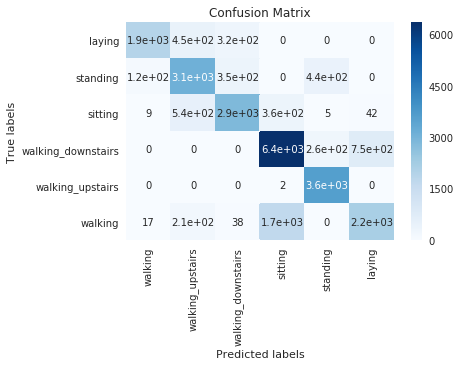

Normalized confusion matrix


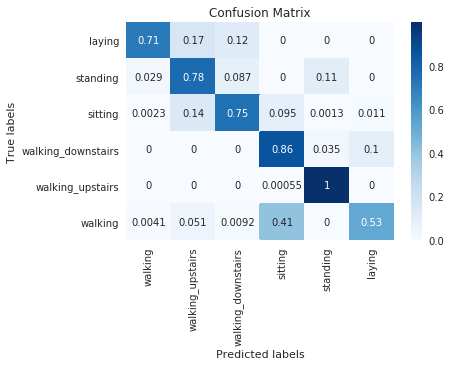

In [58]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
# plt.savefig(save_with_name+'.png')
plt.show()

In [59]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7818883517854358


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       0.93      0.71      0.81      2686
  walking_upstairs       0.72      0.78      0.75      4024
walking_downstairs       0.80      0.75      0.78      3839
           sitting       0.76      0.86      0.81      7360
          standing       0.84      1.00      0.91      3624
            laying       0.73      0.53      0.61      4119

       avg / total       0.78      0.78      0.78     25652



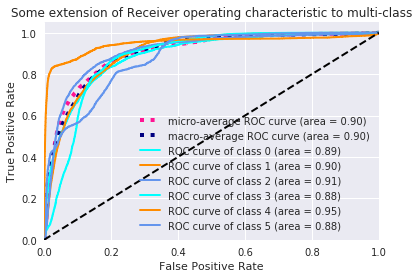

In [64]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)

In [ ]:
# Input Data 

training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test_used)  # 2947 testing series
 
timesteps = len(X_train_used[0]) # 128 timesteps per series
# input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300
# Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X test shape, y test shape, every X's mean, every X's standard deviation)")
print(X_test_used.shape, y_test.shape, np.mean(X_test_used), np.std(X_test_used))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")